In [51]:
import os
import glob
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image as DisplayImage
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

from nnext import NNextClient
from nnext.http.models import Distance
from nnext.conversions.common_types import Record
from nnext.http.models import Filter, FieldCondition

In [43]:
# Connect to NNext
nnclient = NNextClient(host="0.0.0.0", port="6040")
nnclient.get_collections()

CollectionsResponse(collections=[])

In [44]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [45]:
to_tensor = transforms.ToTensor()
layer = model._modules.get('avgpool')

def extract_feature_vector(img):
    t_img = Variable(to_tensor(img).unsqueeze(0))
    my_embedding = torch.zeros(1, 512, 1, 1)

    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = layer.register_forward_hook(copy_data)

    model(t_img)
    h.remove()

    return my_embedding.squeeze().numpy()

In [46]:
# Encode train images
def list_dir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

FEATURE_VEC_LEN = 512 # avgpool layer

feature_vectors = []

train_path = "./data/train/"
folders = list_dir_nohidden(train_path)

for folder in folders:
    folder_path = f"{train_path + folder}/"
    folder_files = [folder_path + filename for filename in list_dir_nohidden(folder_path)]

    with torch.no_grad(): # no gradients calculation for the ops inside this block
        for file_path in folder_files:
            img = Image.open(file_path)
            feature_vec = extract_feature_vector(img)
            feature_vectors.append({"feature_vec": feature_vec.tolist(), "img_path": file_path, "brand": folder})


In [48]:
# Create shoes collection
COLLECTION_NAME = "shoes_collection"

nnclient.recreate_collection(
    collection_name=COLLECTION_NAME,
    vector_size=FEATURE_VEC_LEN,
    distance=Distance.COSINE
)
nnclient.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='shoes_collection')])

In [50]:
def create_metadata(img_path, brand):
	return {
	      "img_path": img_path,
          "brand": brand
	  }

records = [
        Record(
            id=idx,
            vector=feature_vec["feature_vec"],
            payload=create_metadata(feature_vec["img_path"], feature_vec["brand"])
        )
        for idx, feature_vec in enumerate(feature_vectors)
    ]

nnclient.upload_records(
        collection_name=COLLECTION_NAME,
        records=records,
        parallel=2
    )

2022-09-14 13:25:53.707 | INFO     | nnext.parallel_processor:_worker:47 - Reader worker: 0 PID: 51273
2022-09-14 13:25:53.707 | INFO     | nnext.parallel_processor:_worker:47 - Reader worker: 1 PID: 51274
2022-09-14 13:25:54.495 | INFO     | nnext.parallel_processor:_worker:79 - Reader worker 1 finished


In [91]:
brands = ["adidas", "nike", "converse"]
searches = []

for brand in brands:
    test_dir = f"./data/test/{brand}/"
    test_filename = random.choice(os.listdir(test_dir))
    test_img_path = test_dir + test_filename

    with torch.no_grad():
        img = Image.open(test_img_path)
        feature_vec = extract_feature_vector(img).tolist()

    _brand_filter = Filter(
            must=[
                FieldCondition(
                    key="brand",
                    match={"value": brand}
                )
            ]
        )

    shoes_search = nnclient.search(
        collection_name=COLLECTION_NAME,
        query_vector=feature_vec,
        query_filter=_brand_filter,
        append_payload=True,
        limit=4
    )

    searches.append(
        {
            "test_img_path": test_img_path,
            "search": shoes_search,
            "brand": brand 
        }
    )

adidas Test image


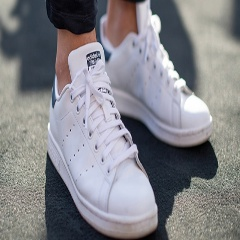

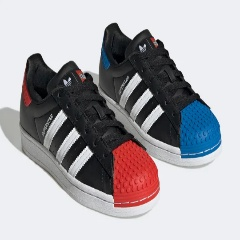

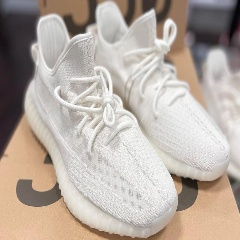

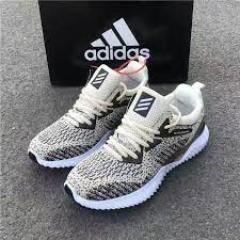

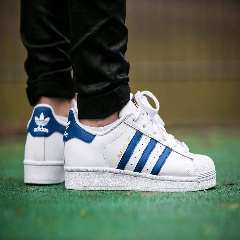

nike Test image


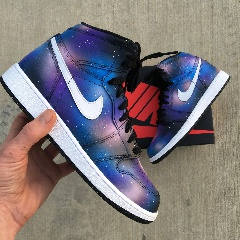

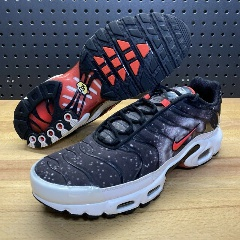

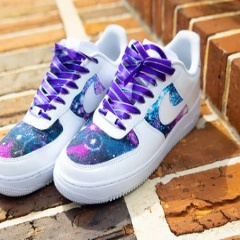

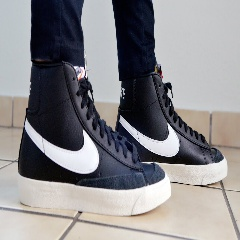

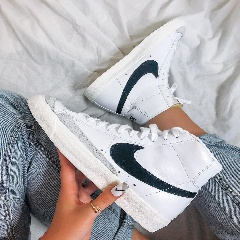

converse Test image


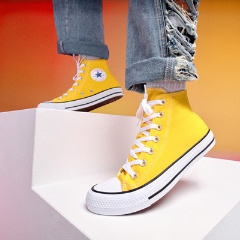

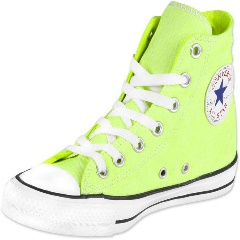

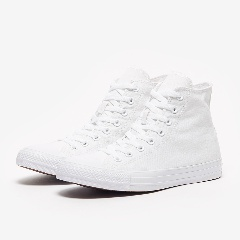

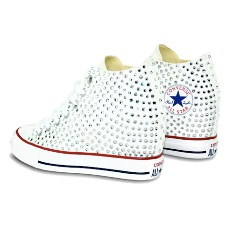

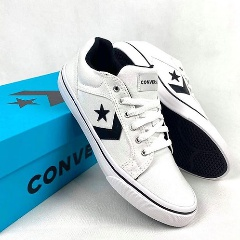

In [100]:
for search in searches:
    print(f"{search['brand']} Test image")
    test_img = DisplayImage(filename=search["test_img_path"])
    shoes_search = search["search"]
    img_1 = DisplayImage(filename=shoes_search[0].payload["img_path"])
    img_2 = DisplayImage(filename=shoes_search[1].payload["img_path"])
    img_3 = DisplayImage(filename=shoes_search[2].payload["img_path"])
    img_4 = DisplayImage(filename=shoes_search[3].payload["img_path"])
    display(test_img, img_1, img_2, img_3, img_4)